In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from sklearn.preprocessing import StandardScaler

In [43]:
df = pd.read_csv('./data/Apple stock.csv')
# last 1000 rows
df = df.tail(1000)

In [44]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
9409,2018-04-06,42.742500,43.119999,42.049999,42.095001,40.373154,140021200
9410,2018-04-09,42.470001,43.272499,42.462502,42.512501,40.773571,116070800
9411,2018-04-10,43.250000,43.500000,42.882500,43.312500,41.540848,113634400
9412,2018-04-11,43.057499,43.480000,42.924999,43.110001,41.346634,89726400
9413,2018-04-12,43.352501,43.750000,43.259998,43.535000,41.754250,91557200


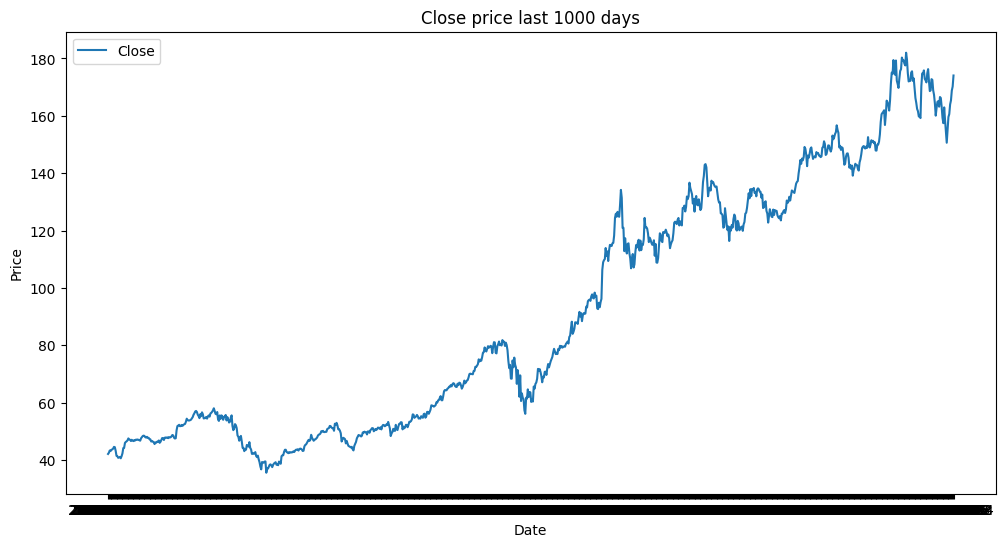

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.title('Close price last 1000 days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
df['RETURNS'] = df['Close'].pct_change()
df['PRX_MA_ND'] = df['Close'].rolling(window=5).mean()
df['VOLATILITY'] = df['Close'].rolling(window=5).std()
df['TP1_RETURNS'] = df['RETURNS'].shift(-1)

df.dropna(inplace=True)
df = df.set_index('Date')

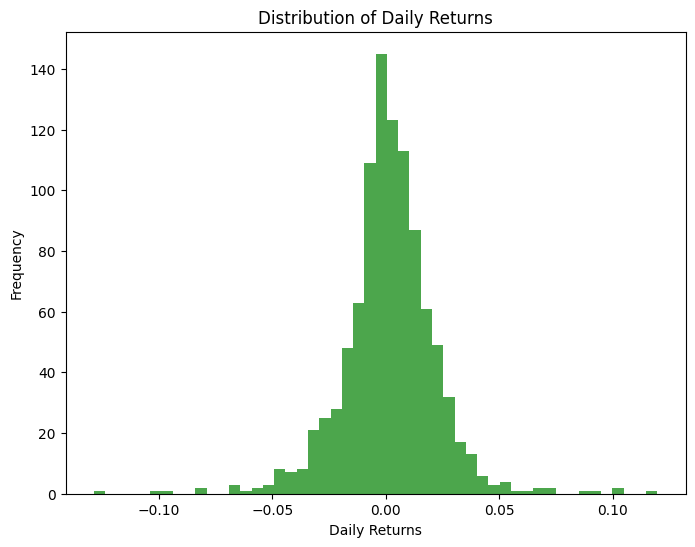

In [47]:
plt.figure(figsize=(8, 6))
plt.hist(df['RETURNS'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

In [48]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(title='Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  xaxis_rangeslider_visible=False)

fig.show()


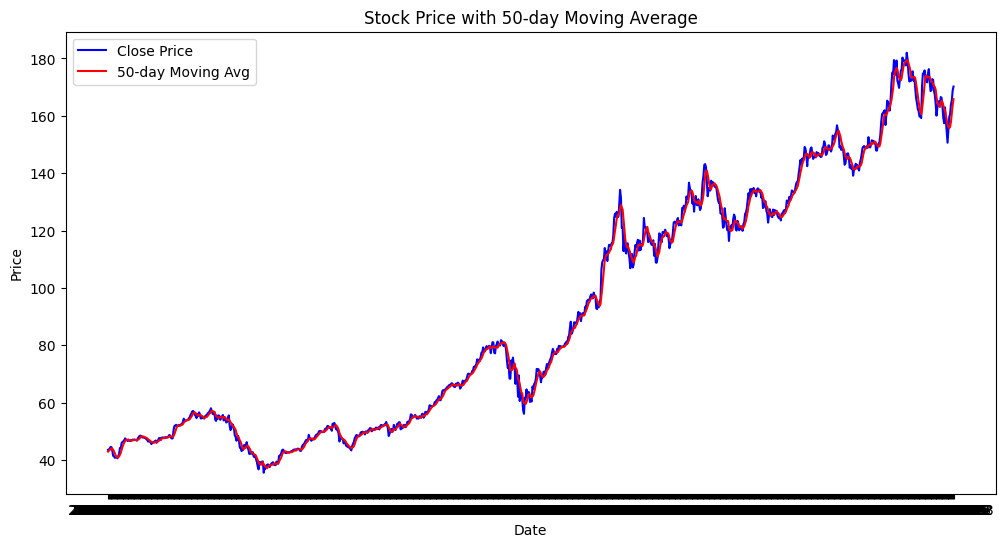

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['PRX_MA_ND'], label='50-day Moving Avg', color='red')
plt.title('Stock Price with 50-day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

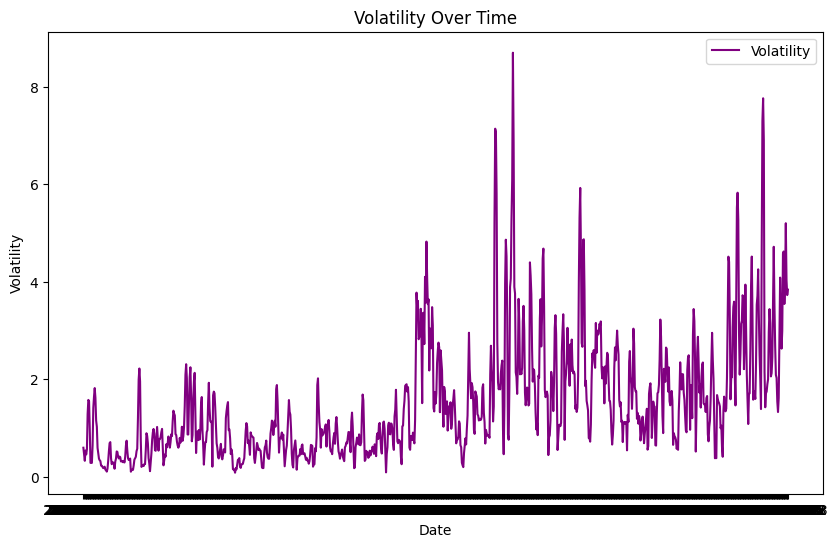

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['VOLATILITY'], label='Volatility', color='purple')
plt.title('Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [51]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,RETURNS,PRX_MA_ND,VOLATILITY,TP1_RETURNS
Date,,,,,,,,,,
2022-03-17,158.610001,161.000000,157.630005,160.619995,160.619995,75615400,0.006454,156.129996,4.047635,0.020919
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,0.020919,157.979996,5.198159,0.008538
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,0.008538,160.931998,4.034302,0.020801
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,0.020801,163.678000,3.724629,0.008234
2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700,0.008234,165.802002,3.836986,0.022678


In [52]:
from sklearn.preprocessing import MinMaxScaler

df_x = df[['RETURNS', 'Volume', 'PRX_MA_ND', 'VOLATILITY']]
df_y = df['TP1_RETURNS']

df_x_scaler = MinMaxScaler().fit(df_x)

forward_test_date = '2021-01-01'

fdf_x = df_x.loc[forward_test_date:]
fdf_y = df_y.loc[forward_test_date:]
df_x = df_x.loc[:forward_test_date]
df_y = df_y.loc[:forward_test_date]

df_x_scaled = pd.DataFrame(df_x_scaler.transform(df_x))
fdf_x_scaled = pd.DataFrame(df_x_scaler.transform(fdf_x))

x_train, x_test, y_train, y_test = train_test_split(df_x_scaled,
                                                    df_y,
                                                    test_size=0.25,
                                                    random_state=42)


In [53]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((515, 4), (172, 4), (515,), (172,))

In [54]:
x_train = np.expand_dims(x_train.values, 1).astype(np.float32)
y_train = np.expand_dims(y_train.values, 1).astype(np.float32)
x_validation = np.expand_dims(x_test.values, 1).astype(np.float32)
y_validation = np.expand_dims(y_test.values, 1).astype(np.float32)

In [55]:
from qcnn.Vqnn import VQNNModel

qnn_model = VQNNModel()
qnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                     beta_1=0.9,
                                                     beta_2=0.999,
                                                     epsilon=1e-07),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=["mean_squared_error"])
qnn_model.run_eagerly = True

In [56]:
import os

log_dir = "./logs/fit/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [57]:
qnn_model.fit(
x_train, y_train, epochs=1, batch_size=1,
              callbacks=[tensorboard_callback])

Job Status: job has successfully run
Job Status: job has successfully run...] - ETA: 2:28 - loss: 0.4820 - mean_squared_error: 0.4820
Job Status: job has successfully run...] - ETA: 43:01 - loss: 0.4619 - mean_squared_error: 0.4619
Job Status: job has successfully run...] - ETA: 42:58 - loss: 0.4600 - mean_squared_error: 0.4600
Job Status: job has successfully run...] - ETA: 42:54 - loss: 0.4570 - mean_squared_error: 0.4570
Job Status: job has successfully run...] - ETA: 42:50 - loss: 0.4495 - mean_squared_error: 0.4495
Job Status: job has successfully run...] - ETA: 42:45 - loss: 0.4485 - mean_squared_error: 0.4485
Job Status: job has successfully run...] - ETA: 42:40 - loss: 0.4415 - mean_squared_error: 0.4415
Job Status: job has successfully run...] - ETA: 42:36 - loss: 0.4415 - mean_squared_error: 0.4415
Job Status: job has successfully run...] - ETA: 42:31 - loss: 0.4421 - mean_squared_error: 0.4421
Job Status: job has successfully run...] - ETA: 42:26 - loss: 0.4411 - mean_square

In [58]:
num_of_features = fdf_x_scaled.shape[1]
qnn_predictions = []
for entry in fdf_x_scaled.iterrows():
    fdf_x_predict_tensor = tf.reshape(tf.convert_to_tensor(entry[1]), [1, num_of_features])
    qnn_forecast = qnn_model.predict(fdf_x_predict_tensor)
    qnn_predictions.append(qnn_forecast[-1, -1, -1])
signal = [0 if x <= 0 else 1 for x in qnn_predictions]

Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [=

In [61]:
qnn_predictions

[-0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.06180787,
 -0.047355592,
 -0.0545817,
 -0.0545817,
 -0.047355592,
 -0.0545817,
 -0.07881054,
 -0.06265801,
 -0.0545817,
 -0.0545817,
 -0.047355592,
 -0.06180787,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.06180787,
 -0.0545817,
 -0.047355592,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.047355592,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.06180787,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.06180787,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.047355592,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.0545817,
 -0.05

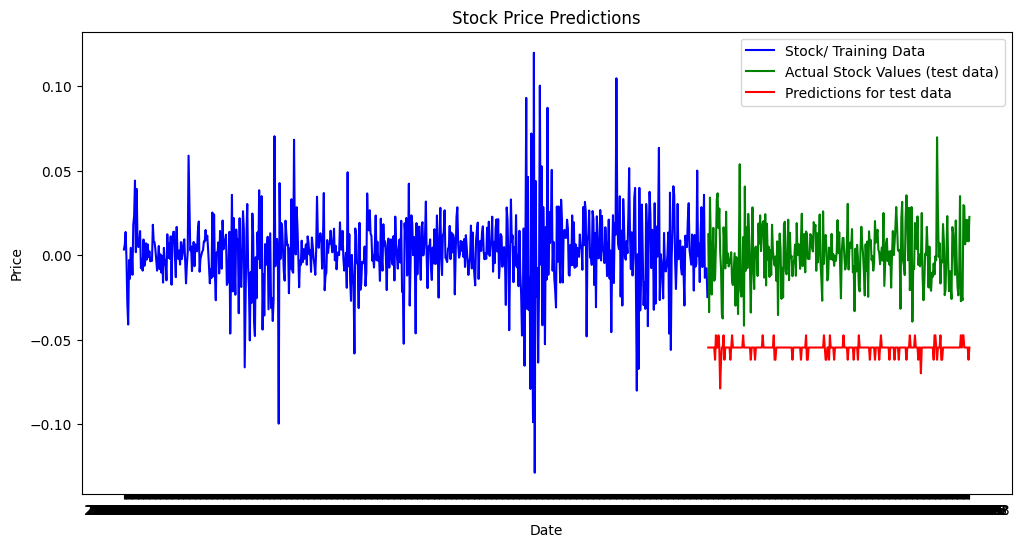

In [59]:
# plot all the data, train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(df_y.index, df_y, label='Stock/ Training Data', color='blue')
plt.plot(fdf_y.index, fdf_y, label='Actual Stock Values (test data)', color='green')
plt.plot(fdf_y.index, qnn_predictions, label='Predictions for test data', color='red')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ATTENTION
This was an expirment with quantum only, it was not great either. And it will never finish running with the full dataset

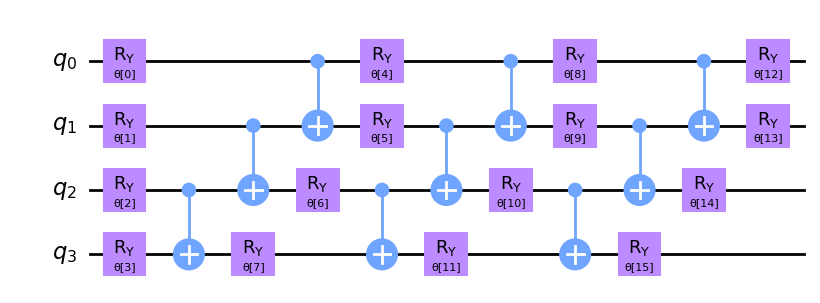

In [32]:
from qiskit_algorithms.optimizers import ADAM, L_BFGS_B, COBYLA, GradientDescent
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes, ZZFeatureMap

num_features = x_train.shape[1]
# feature_map = PauliFeatureMap(feature_dimension=num_features, reps=2)
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
# optimizer = L_BFGS_B(maxiter=5) # takes too long 
# optimizer = COBYLA(maxiter=30) # innacurate   
optimizer = COBYLA(maxiter=100)
# optimizer = GradientDescent(maxiter=60)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [33]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    print(f"Iteration: {len(objective_func_vals)}")
    print(f"Objective function value: {obj_func_eval}")
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [34]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

Iteration: 99
Objective function value: 0.018757807795068294


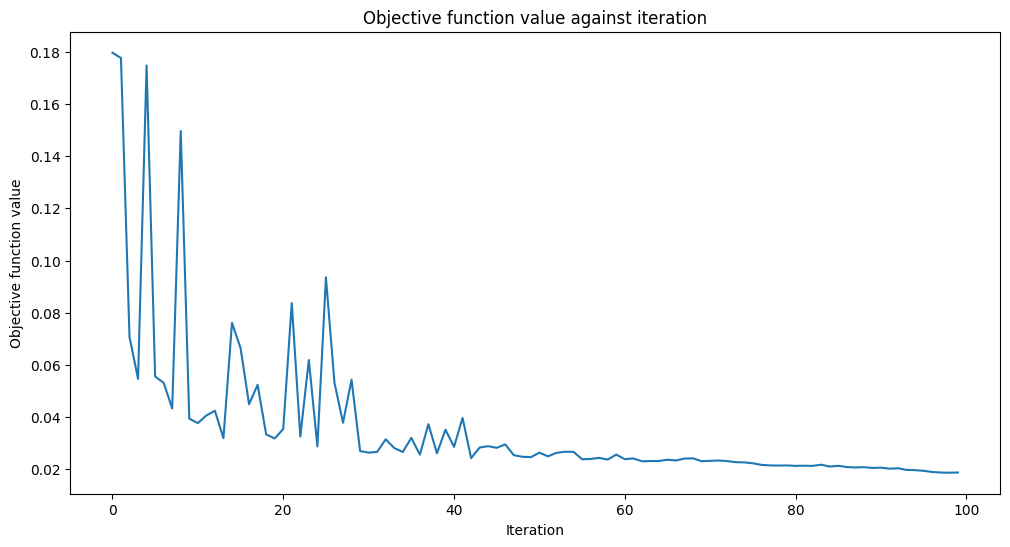

-35.1073580699596

In [35]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(x_train, y_train)

In [36]:
vqr.score(x_test, y_test)

-32.097609399006586

In [37]:
from sklearn.metrics import mean_squared_error

vqr_mse = mean_squared_error(y_test, vqr.predict(x_test))

# Calculate root mean squared error
vqr_rmse = np.sqrt(vqr_mse)

print("Root Mean Squared Error VQR: ", vqr_rmse)
print("Mean Squared Error VQR: ", vqr_mse)

Root Mean Squared Error VQR:  0.12744390963327504
Mean Squared Error VQR:  0.016241950102614377


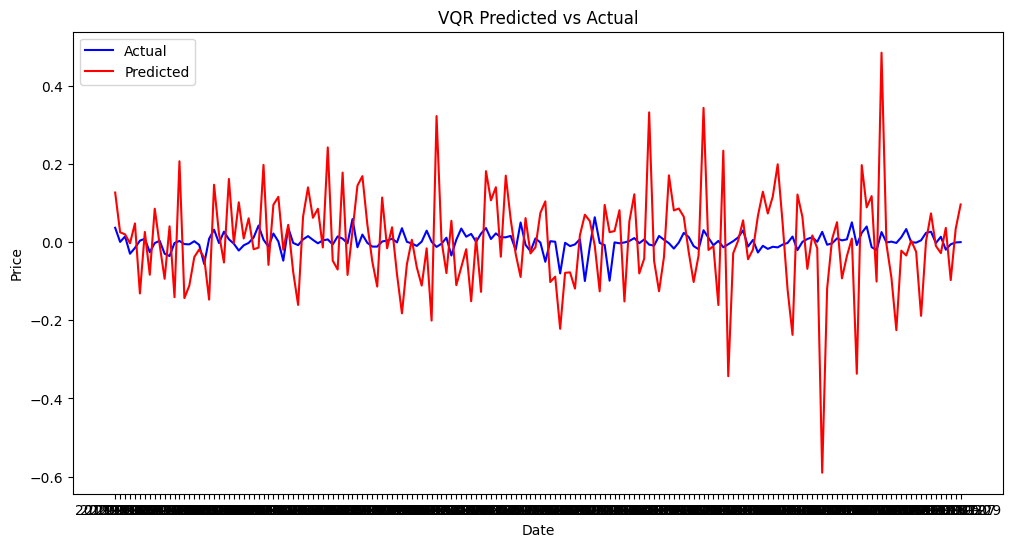

In [40]:
# plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, vqr.predict(x_test), label='Predicted', color='red')
plt.title('VQR Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()